# Linear Regression

Small linear regression sample implementation.
For this example we are using the Bitcoin Prices in a Monthly basis as the **dependant** variable. i.e., the variable we want to predict. 
And we use the Usa Inflation Rates in a Montly basis as the **independant** variable. i.e., the variable we are using **to** predict the Bitcoin price. 

> DISCLAIMER: this is simplified given that yahoo offers good quality data. Usually you need more steps to clean and wrangle data.

## 1. Import libraries

In [188]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 2. Load the data from csv files.

In [189]:
# Ingest
## Data paths.
DATA = "assets/BTC-USD.csv" 
DATA1 = "assets/US-Inflation-rates.csv"

## Make pandas read the data.
pd.options.mode.copy_on_write = True
df1 = pd.read_csv(DATA, index_col="Date", parse_dates=True).sort_index(ascending=True)
df2 = pd.read_csv(DATA1)

Ingests the data fetched from Yahoo Finance (The data has no blank values).
During the import, the data is formated to a time series by setting the Dates as the index. The index is then sorted as ascend given that for linear regresions these need to be from older to newest.

In [190]:
df1.head()
df2.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914,2,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915,1,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916,3,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


## 3. Preprocess the data for the regression.

### 3.1 Wrangle Data

In [191]:
## Turn month columns into a month column with month values.
df2 = df2.drop(columns=["Ave"])  # Yearly average is not needed.
df2 = df2.rename(  # Rename columns so we can sort them.
    columns={
        "Jan": "01",
        "Feb": "02",
        "Mar": "03",
        "Apr": "04",
        "May": "05",
        "Jun": "06",
        "Jul": "07",
        "Aug": "08",
        "Sep": "09",
        "Oct": "10",
        "Nov": "11",
        "Dec": "12",
    }
).melt(
    df2.columns[0]
)  # Convert columns to values.

## Create Date column.
df2["Date"] = (
    df2.astype({"Year": "str"}).Year + "-" + df2.astype({"variable": "str"}).variable
)

df2 = df2.drop(columns=["variable", "Year"]).sort_values("Date", ascending=True)
df2 = df2.reset_index()
df2.head()

,index,value,Date
0,0,2,1914-01
1,111,1.0,1914-02
2,222,1.0,1914-03
3,333,0.0,1914-04
4,444,2.1,1914-05


In [192]:
# Make sure number values are numbers.
df2.dtypes  # We can see it is object type.
df2['value'] = pd.to_numeric(df2.value, errors = 'coerce')  # Use coerce to force words to NaN.

# Remove Na's
df2.tail()  # Current year will have missing values. 
df2 = df2.dropna()
df2 = df2.reset_index()
df2 = df2.drop(columns=["index"])  # Re assing table indexes since we moved and deleted stuff.

### 3.2 Level Sample Sizes

In [193]:
if df1.shape[0] != df2.shape[0]:
  print ("Sample sizes don't match")
  df2 = df2.loc[df2.shape[0] - df1.shape[0] -1 : ]


Sample sizes don't match


In this instance we are going to use Inflation_1 (lag = 1) to predict. Other methods could be to use a rolling average to predict the last month prices if it isn't avaliable yet or an orquest ensamble that predicts Inflation, then predicts prices. 

### 3.2 Select Data

In [202]:
## Get the correlation
df3 = pd.concat([df1.reset_index(),df2.reset_index()], axis=1)
df3 = df3[['Adj Close', 'value']]
df3.corr()

,Adj Close,value
Adj Close,1.000000,0.334609
value,0.334609,1.000000


In [170]:
## Get necesary predictive values only.
# Use double brackets to avoid sending pandas.core.series.Series instead of DataFrame
dfx = df2[["value"]]  # Load the Etherum price as x (Independant)
dfy = df1[["Adj Close"]]  # Load the Bitcoin price as y (Dependant)

Viewing the data shows the varying measures for the exchange prices. We need to **drop** all of them except the "Adj Close".

Notice that unlike the correlation. We fetch the columns using **double brackets**. 
This is to avoid getting errors in scikit-learn given that we are using 1 variable as preditor instead of a multy plexed array (a matrix).

## 4. Split the sets

In [122]:
train_size = 0.8  # use 80 percent to train the regression
if dfx.shape[0] != dfy.shape[0]:
    print("Sample Sizes ERROR")
    exit
x_train_size = round(dfx.shape[0] * train_size)  # We only need the rows.
x_test_size = x_train_size
y_train_size = round(dfx.shape[0] * train_size)  # We only need the rows.
y_test_size = y_train_size

x_train, x_test = dfx.iloc[:x_train_size], dfx.iloc[x_test_size:]
y_train, y_test = dfy.iloc[:y_train_size], dfy.iloc[y_test_size:]

Why not use all the series for the regression?
To avoid overfitting. 

## 5. Regression

In [126]:
# Regression
regressor = LinearRegression()
regressor.fit(X=x_train, y=y_train)
regressor.coef_

array([[2536.71878289]])

Create a Linear Regression instance and then fit it to the linear regression we need.  
**x** is the Ethereum price.  
**y** is the Bitcoin price.  

## 6. Predict 

In [124]:
y_pred = regressor.predict(x_test)
print(y_pred)

[[30271.62357028]
 [29256.93605713]
 [26720.21727424]
 [26466.54539595]
 [24183.49849136]
 [21646.77970847]
 [22154.12346505]
 [23422.48285649]
 [23422.48285649]
 [22154.12346505]
 [21900.45158676]
 [22661.46722162]]


Create an array with the predictions for the **test (Validation)** set.  
Print the predictions. 

## 7. Plot.

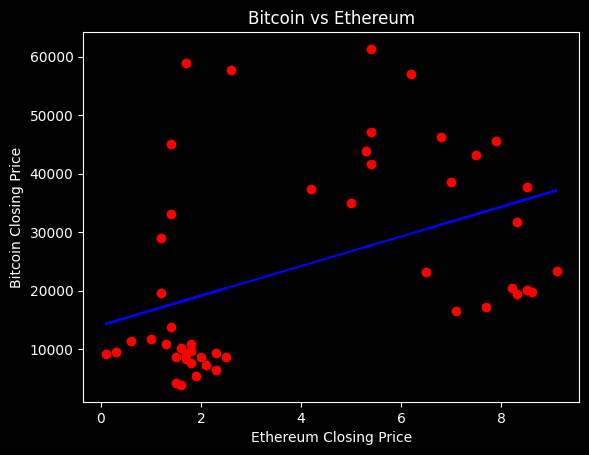

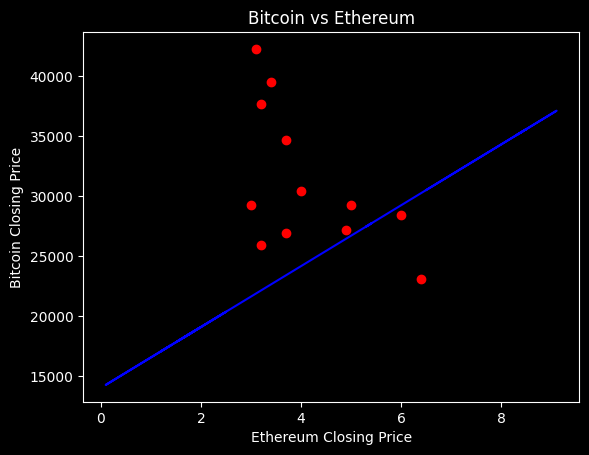

In [125]:
# Training Sets
plt.scatter(x_train, y_train, color="red")
plt.plot(x_train, regressor.predict(x_train), color="blue")
plt.title("Bitcoin vs Ethereum")
plt.xlabel("Ethereum Closing Price")
plt.ylabel("Bitcoin Closing Price")
plt.show()


# Test set
plt.scatter(x_test, y_test, color="red")
plt.plot(x_train, regressor.predict(x_train), color="blue")
plt.title("Bitcoin vs Ethereum")
plt.xlabel("Ethereum Closing Price")
plt.ylabel("Bitcoin Closing Price")
plt.show()
